# Doc2Vec test

In [1]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import namedtuple, Counter
from random import shuffle
import pickle
import pandas as pd
import multiprocessing
import time
import numpy as np
import re
import random
import matplotlib.pyplot as plt


%matplotlib inline

numcores = multiprocessing.cpu_count()

In [2]:
def standardtext(df, textfield):
    newcolname = 'norm'+textfield
    df[newcolname] = df[textfield].str.replace(u'\xa0', u' ')
    df[newcolname] = df[newcolname].str.replace(u'\xa0', u' ')
    df[newcolname] = df[newcolname].str.replace(u'/', u' ')
    df[newcolname] = df[newcolname].str.replace(u'\\', u' ')
    df[newcolname] = df[newcolname].str.replace(u'\u201C', '"')
    df[newcolname] = df[newcolname].str.replace(u'\u201D', '"')
    df[newcolname] = df[newcolname].str.replace(u'\u2018', '\'')
    df[newcolname] = df[newcolname].str.replace(u'\u2019', '\'')
    df[newcolname] = df[newcolname].str.replace('…', '\'')
    df[newcolname] = df[newcolname].str.replace('\t', ' ')
    df[newcolname] = df[newcolname].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[newcolname] = df[newcolname].str.replace(r"[\'\`]s", "")
    df[newcolname] = df[newcolname].str.lower()
    
    # Pad punctuation with spaces on both sides
    for char in ['.', '"', ',', '(', ')', '!', '?', ';', ':']:
        df[newcolname] = df[newcolname].str.replace(char, ' ' + char + ' ')
    return df

In [3]:
# TEST THE DISTANCE BETWEEN N DOCUMENTS AND THEMSELVES
def testself(vectortest, N=100):
    testdoc_id = list(np.random.choice(aotable['id'], size=N, replace=False).astype('str'))
    indicesmatch = {}
    cosinematch = {}
    cosinemean = {}

    for testmodel in vectortest:
        modelname = re.sub(' ', '_', testmodel.comment)
        indicesmatch[modelname] = []
        cosinematch[modelname] = []
        cosinemean[modelname] = []


        for docs in testdoc_id:
            # grab the document from the list of named tuples
            testdoc = [x for x in allao if docs in x.tags][0]
            testvec = testmodel.infer_vector(testdoc.words) # document
            # run through the model
            matchtest = testmodel.docvecs.most_similar([testvec], topn = model.docvecs.count)

            # find the index and the cosine similarity of the match of the document to itself
            cosinemean[modelname].append(np.mean([b for a,b in matchtest]))
            for index,value in enumerate(matchtest):
                if value[0] == docs:
                    indicesmatch[modelname].append(index)
                    cosinematch[modelname].append(value[1])
    return indicesmatch, cosinematch, cosinemean
        
    

In [20]:
# PLOT TEST RESULTS
def plotvectortest(t_ind, t_cos, t_mean):
    plt.figure(figsize=(20,20))

    plt.subplot(2,2,1)
    for key in t_cos:
        plt.hist(t_cos[key], bins=30, label=key, alpha=0.5)

    #plt.xlim(-1, 1)
    plt.legend(loc='upper left')
    plt.title('Similarity to itself', fontsize=20)
    plt.xlabel('Cosine similarity', fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel('Frequency', fontsize=16)
    plt.yticks(fontsize=14)
    #plt.show()

    plt.subplot(2,2,2)
    for key in t_mean:
        plt.hist(t_mean[key], bins = 30, label=key, alpha=0.5)

    #plt.xlim(-1, 1)
    plt.legend(loc='upper right')
    plt.title('Similarity to other documents', fontsize=20)
    plt.xlabel('Cosine similarity', fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel('Frequency', fontsize=16)
    plt.yticks(fontsize=14)    
    #plt.show()

    plt.subplot(2,2,3)
    for key in t_ind:
        plt.hist(t_ind[key], bins = 30, label=key, alpha=0.5)

    plt.legend(loc='upper left')
    plt.title('Rank similarity to self', fontsize=20)
    plt.xlabel('Rank', fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel('Frequency', fontsize=16)
    plt.yticks(fontsize=14)    
    #plt.show()

    plt.subplot(2,2,4)
    for key in t_cos:
        plt.hist(np.array(t_cos[key]) / np.array(t_mean[key]), bins = 30, label=key, alpha=0.5)

    plt.legend(loc='upper right')
    plt.title('self:mean cosine similarity ratio', fontsize=20)
    plt.xlabel('Cosine similarity ratio', fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel('Frequency', fontsize=16)
    plt.yticks(fontsize=14)    


In [5]:
# Load AO data
aotable = pickle.load(open('data/AOmasterdata-nodup-week4-clean', 'rb'))
aotable.head(3)

,id,title,subtitle,city,country,location,url,physical_status,lat,lng,keywords,description,imgurl,subdesc,normsubdesc,tokens,weirdness,weirdpct
0,5561,Lake Hillier,An Australian lake whose pink hue defies scien...,,Australia,Australia,https://www.atlasobscura.com/places/lake-hillier,,-34.094179,123.203276,"wonders of salt,natural wonders,watery wonders","From a distance, Lake Hillier of Australia’s R...",https://assets.atlasobscura.com/media/W1siZiIs...,An Australian lake whose pink hue defies scien...,an australian lake whose pink hue defies scien...,"[an, australian, lake, whose, pink, hue, defie...",0.132377,26.78
1,4290,Gippsland Lakes Bioluminescence,Australian Lake set aglow by Noctiluca Scintil...,Raymond Island,Australia,"Raymond Island, Australia",https://www.atlasobscura.com/places/lake-gipps...,,-37.922431,147.791342,"watery wonders,bioluminescence","The conditions were rare, and they were perfec...",https://assets.atlasobscura.com/media/W1siZiIs...,Australian Lake set aglow by Noctiluca Scintil...,australian lake set aglow by noctiluca scintil...,"[australian, lake, set, aglow, by, noctiluca, ...",0.142318,4.00
2,596,The Haunted Bookshop,"Occult books, Tarot, Oddities.",Melbourne,Australia,"Melbourne, Australia",https://www.atlasobscura.com/places/haunted-bo...,,-37.815472,144.961689,"repositories of knowledge,occult,bookstores",The creepy Haunted Bookshop in Melbourne is lo...,https://assets.atlasobscura.com/media/W1siZiIs...,"Occult books, Tarot, Oddities.The creepy Haunt...","occult books , tarot , oddities the creepy h...","[occult, books, tarot, oddities, the, creepy, ...",0.122837,70.29


In [6]:
allao = pickle.load(open('data/taggeddocs-week4-clean', 'rb'))
print(allao[0])
print(len(allao))

TaggedDocument(['an', 'australian', 'lake', 'whose', 'pink', 'hue', 'defies', 'scientific', 'explanation', 'from', 'a', 'distance', 'lake', 'hillier', 'of', 'australia', 'recherche', 'archipelago', 'looks', 'like', 'a', 'swath', 'of', 'solid', 'bubble', 'gum', 'pink', 'draw', 'closer', 'and', 'the', 'color', 'takes', 'on', 'a', 'more', 'watery', 'translucent', 'quality', 'but', 'remains', 'unmistakably', 'pink', 'whereas', 'the', 'causes', 'behind', 'the', 'unusual', 'coloring', 'of', 'other', 'pink', 'lakes', 'such', 'as', 'the', 'nearby', 'pink', 'lake', 'and', 'senegal', 'lake', 'retba', 'have', 'been', 'definitively', 'confirmed', 'the', 'reason', 'for', 'lake', 'hillier', 'color', 'remains', 'a', 'mystery', 'theories', 'abound', 'of', 'course', 'some', 'speculate', 'that', 'lake', 'hillier', 'color', 'like', 'that', 'of', 'the', 'other', 'lakes', 'is', 'the', 'result', 'of', 'high', 'salinity', 'combined', 'with', 'the', 'presence', 'of', 'a', 'salt', 'loving', 'algae', 'species',

# Testing the effect of vector size

In [7]:
%%time

initalpha = 0.05
genstorun = 20
alphastep = initalpha*0.9/genstorun

sizetest = [
    Doc2Vec(dm=0, dbow_words=1, vector_size=100, window=8, epochs= 50, min_count=2, alpha=initalpha, min_alpha=initalpha, workers=numcores, comment='100 vectors'),
    Doc2Vec(dm=0, dbow_words=1, vector_size=200, window=8, epochs= 50, min_count=2, alpha=initalpha, min_alpha=initalpha, workers=numcores, comment='200 vectors'),
    Doc2Vec(dm=0, dbow_words=1, vector_size=300, window=8, epochs= 50, min_count=2, alpha=initalpha, min_alpha=initalpha, workers=numcores, comment='300 vectors'),
    Doc2Vec(dm=0, dbow_words=1, vector_size=400, window=8, epochs= 50, min_count=2, alpha=initalpha, min_alpha=initalpha, workers=numcores, comment='400 vectors'),
    Doc2Vec(dm=0, dbow_words=1, vector_size=500, window=8, epochs= 50, min_count=2, alpha=initalpha, min_alpha=initalpha, workers=numcores, comment='500 vectors'),
    Doc2Vec(dm=0, dbow_words=1, vector_size=600, window=8, epochs= 50, min_count=2, alpha=initalpha, min_alpha=initalpha, workers=numcores, comment='600 vectors')
]

for model in sizetest:
    model.build_vocab(allao)
    print("%s vocabulary scanned & state initialized" % model.comment)
    
for model in sizetest: 
    print("Training %s" % model.comment)
    aoshuf = allao[:]  
    for epoch in range(genstorun):
        shuffle(aoshuf)
        model.train(aoshuf, total_examples=model.corpus_count, epochs=1)
        model.alpha -= alphastep
        model.min_alpha = model.alpha

100 vectors vocabulary scanned & state initialized
200 vectors vocabulary scanned & state initialized
300 vectors vocabulary scanned & state initialized
400 vectors vocabulary scanned & state initialized
500 vectors vocabulary scanned & state initialized
600 vectors vocabulary scanned & state initialized
Training 100 vectors
Training 200 vectors
Training 300 vectors
Training 400 vectors
Training 500 vectors
Training 600 vectors
CPU times: user 2h 34min 30s, sys: 24.1 s, total: 2h 34min 54s
Wall time: 41min 36s


In [8]:
sizeindtest, sizecostest, sizemeantest = testself(sizetest, N=1000)

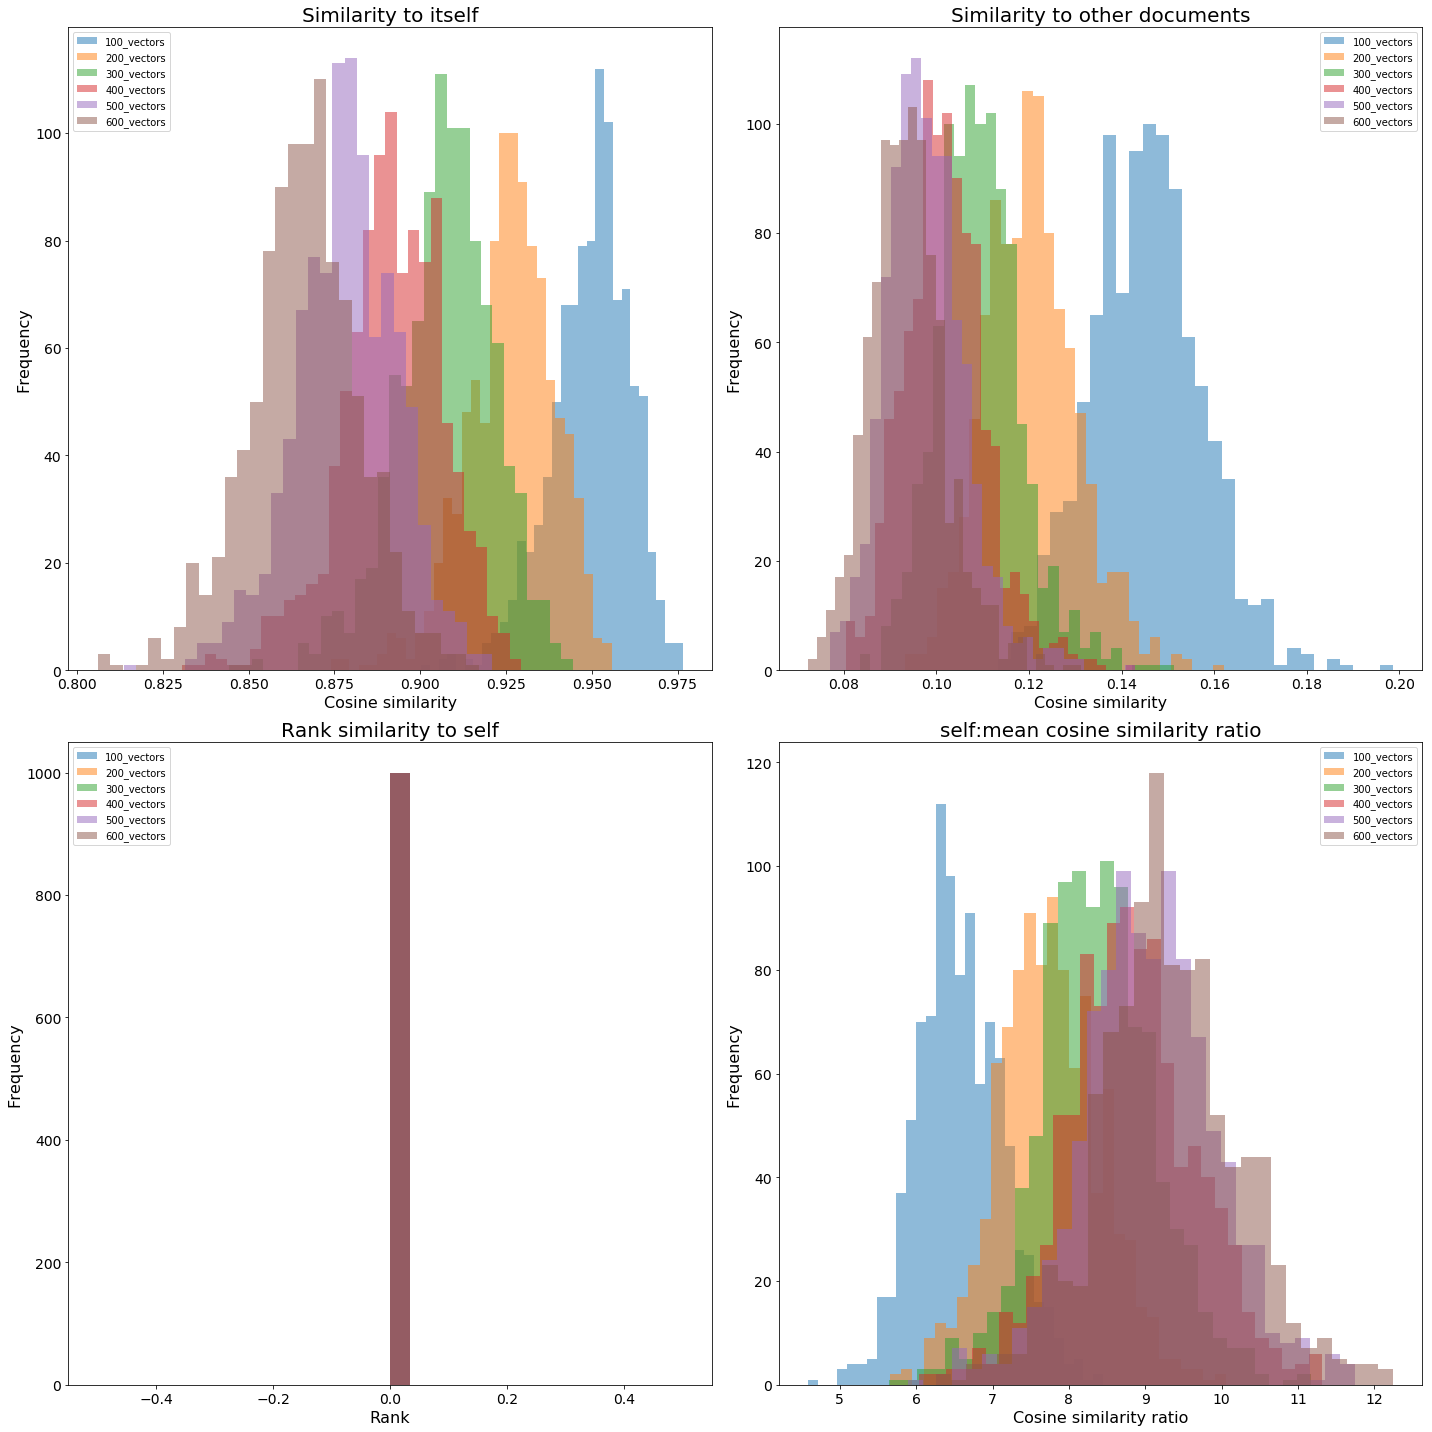

In [21]:
plotvectortest(sizeindtest, sizecostest, sizemeantest)
plt.tight_layout()
plt.savefig('fig/OPT_vectors.jpg', format='jpg', dpi=300)
plt.show()

In [10]:
sizeratiotest = {}

for key in sizemeantest:
    sizeratiotest[key] = np.array(sizecostest[key]) / np.array(sizemeantest[key])

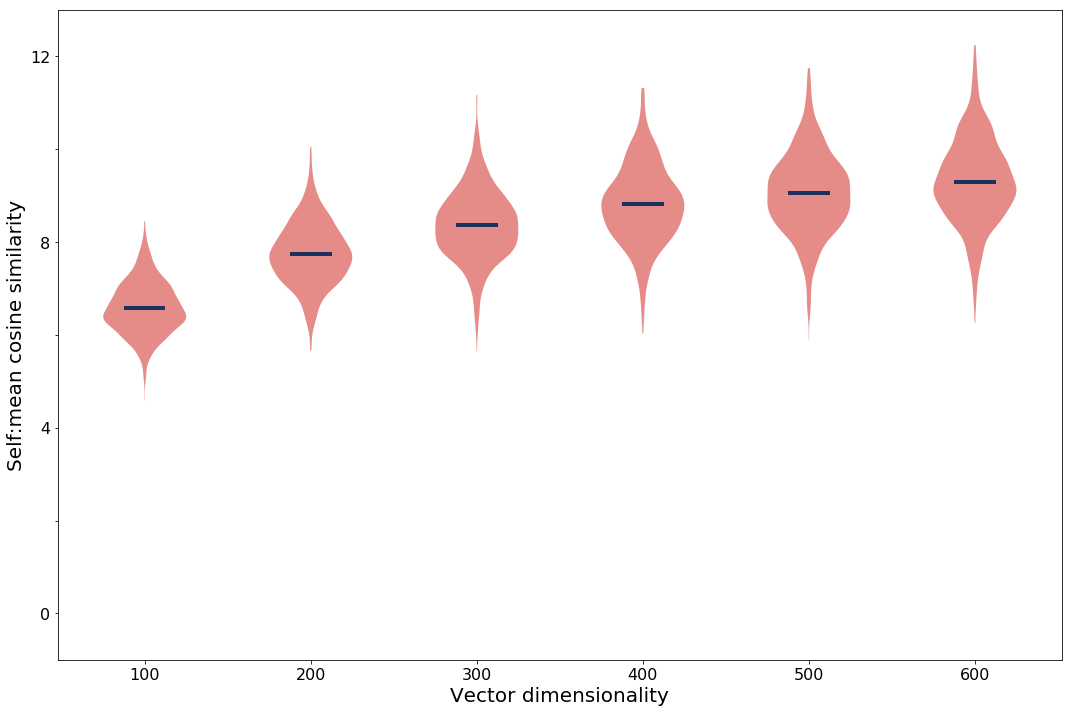

In [11]:
plt.figure(figsize=[15,10])
ax = plt.subplot(111)
pt = plt.violinplot(pd.DataFrame.from_dict(sizeratiotest, orient='index'), showmeans=True, showextrema=False)
for p in pt['bodies']:
    p.set_facecolor('#D43F3A')
    p.set_alpha(0.6)

pt['cmeans'].set_color('#1b325fff')
pt['cmeans'].set_linewidth(4)

ax.set_xticklabels([0,100,200,300,400,500,600], fontsize=16)
ax.set_ylim(-1,13)
ax.set_yticklabels(['',0,'',4,'',8,'',12],fontsize=16)
ax.set_ylabel('Self:mean cosine similarity', fontsize=20)
ax.set_xlabel('Vector dimensionality', fontsize=20)
plt.tight_layout()
plt.savefig('fig/OPT_vectors2.jpg', format='jpg', dpi=300)
plt.show()

# Testing the effect of different alphas

In [12]:
%%time

alphatest = [
    Doc2Vec(dm=0, dbow_words=1, vector_size=150, window=8, epochs=50, min_count=2, alpha=0.025, min_alpha=0.025, workers=numcores, comment='alpha 0.025'),
    Doc2Vec(dm=0, dbow_words=1, vector_size=150, window=8, epochs=50, min_count=2, alpha=0.050, min_alpha=0.050, workers=numcores, comment='alpha 0.050'),
    Doc2Vec(dm=0, dbow_words=1, vector_size=150, window=8, epochs=50, min_count=2, alpha=0.075, min_alpha=0.075, workers=numcores, comment='alpha 0.075')
]

for model in alphatest:
    model.build_vocab(allao)
    print("%s vocabulary scanned & state initialized" % model.comment)
    
for model in alphatest: 
    print("Training %s" % model.comment)
    aoshuf = allao[:]  
    genstorun = 50
    alphastep = model.alpha*0.9/genstorun
    for epoch in range(genstorun):
        shuffle(aoshuf)
        model.train(aoshuf, total_examples=model.corpus_count, epochs=1)
        model.alpha -= alphastep
        model.min_alpha = model.alpha

alpha 0.025 vocabulary scanned & state initialized
alpha 0.050 vocabulary scanned & state initialized
alpha 0.075 vocabulary scanned & state initialized
Training alpha 0.025
Training alpha 0.050
Training alpha 0.075
CPU times: user 2h 16min 44s, sys: 20.1 s, total: 2h 17min 4s
Wall time: 36min 38s


In [13]:
alphaindtest, alphacostest, alphameantest = testself(alphatest, N=1000)

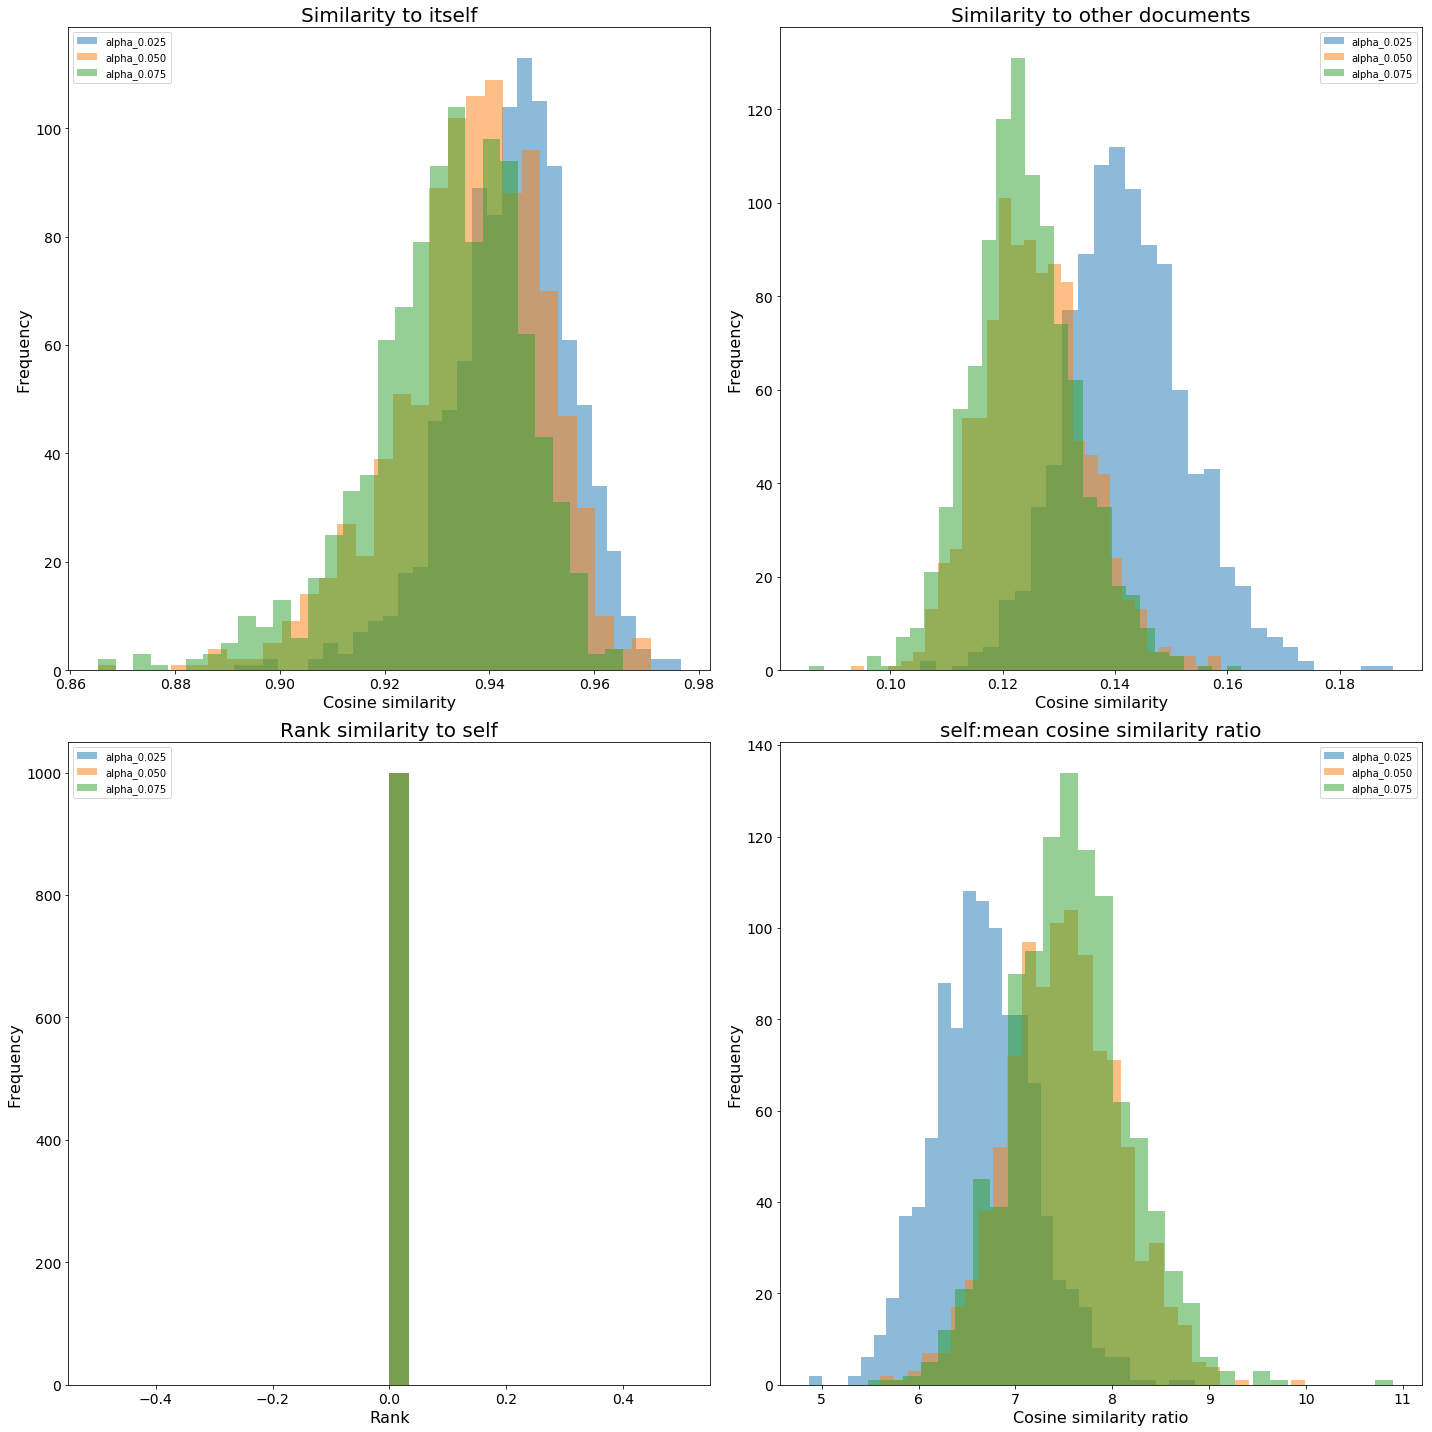

In [22]:
plotvectortest(alphaindtest, alphacostest, alphameantest)
plt.tight_layout()
plt.savefig('fig/OPT_alpha.jpg', format='jpg', dpi=300)
plt.show()

# Testing the effect of the number of iterations

In [15]:
%%time

itertest = [
    Doc2Vec(dm=0, dbow_words=1, vector_size=150, window=8, epochs=  20, min_count=2, alpha=0.050, min_alpha=0.05, workers=numcores, comment='20 epochs'),
    Doc2Vec(dm=0, dbow_words=1, vector_size=150, window=8, epochs=  50, min_count=2, alpha=0.050, min_alpha=0.05, workers=numcores, comment='50 epochs'),
    Doc2Vec(dm=0, dbow_words=1, vector_size=150, window=8, epochs= 100, min_count=2, alpha=0.050, min_alpha=0.05, workers=numcores, comment='100 epochs')
]

for model in itertest:
    model.build_vocab(allao)
    print("%s vocabulary scanned & state initialized" % model.comment)
    
for model in itertest: 
    print("Training %s" % model.comment)
    aoshuf = allao[:]  
    genstorun = model.epochs
    alphastep = model.alpha*0.9/genstorun
    for epoch in range(genstorun):
        shuffle(aoshuf)
        model.train(aoshuf, total_examples=model.corpus_count, epochs=1)
        model.alpha -= alphastep
        model.min_alpha = model.alpha

20 epochs vocabulary scanned & state initialized
50 epochs vocabulary scanned & state initialized
100 epochs vocabulary scanned & state initialized
Training 20 epochs
Training 50 epochs
Training 100 epochs
CPU times: user 2h 34min 58s, sys: 25.3 s, total: 2h 35min 23s
Wall time: 42min 21s


In [16]:
iterindtest, itercostest, itermeantest = testself(itertest, N=1000)

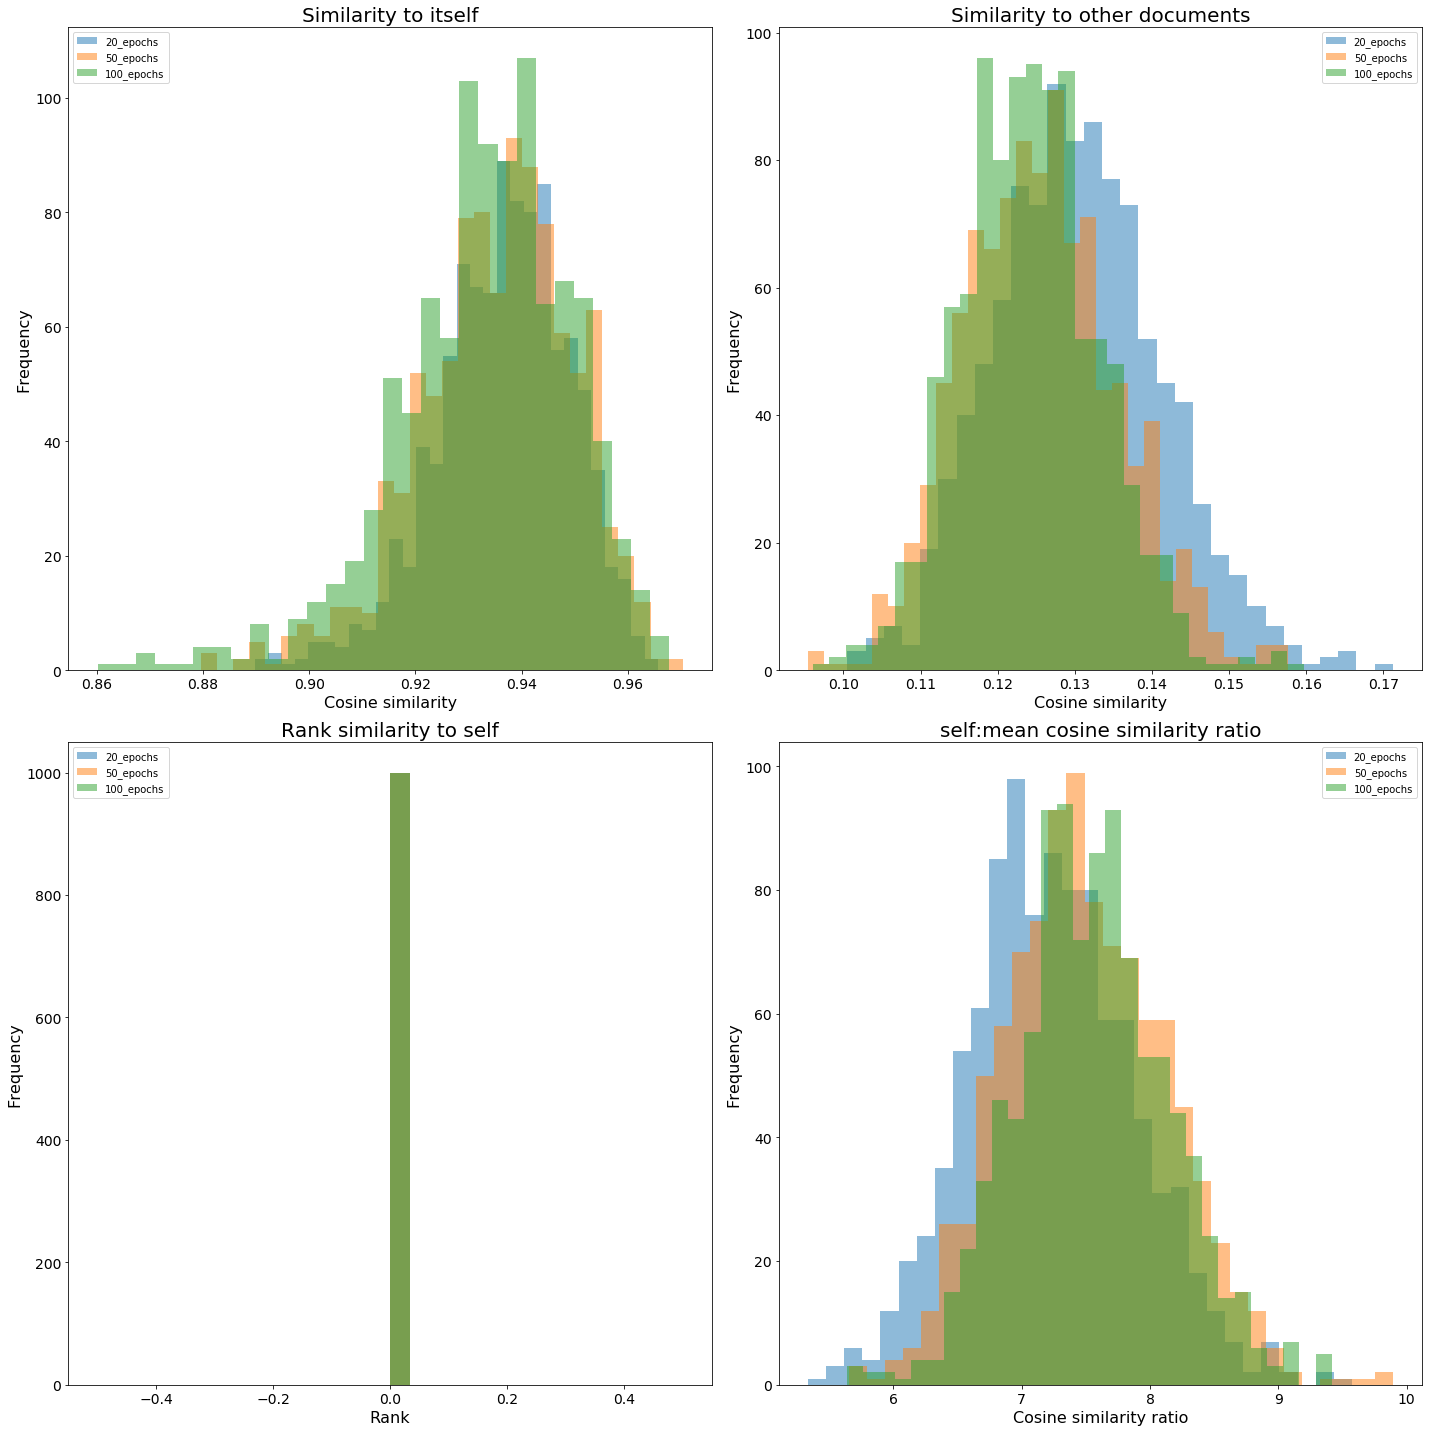

In [23]:
plotvectortest(iterindtest, itercostest, itermeantest )
plt.tight_layout()
plt.savefig('fig/OPT_alpha.jpg', format='jpg', dpi=300)
plt.show()